# This notebook will plot the distribution of V1 cell responses to static gratings. The data is 2P calcium responses in the mouse brain, from the Allen Brain Observatory. 

# The point is to compare the sparsity of responses to static gratings to that during natural scenes. This is a valid comparison because the static grating stimulus conditions are very similar to the natural scene conditions.


# First load the data for a sample mouse

In [1]:
#load data (V1, natural image responses) for a sample mouse
import os
import platform
import pandas as pd
import numpy as np
import cPickle as cpickle

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info


#sets the drive path of hard-disk containing observatory data, based on current OS
if platform.system()=='Windows':
    drive_path = 'g:/'
else:
    drive_path = '/Volumes/Brain2016 3/'

manifest_path = os.path.join(drive_path, 'BrainObservatory/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
print(cre_lines)

structures = boc.get_all_targeted_structures()
print("\nall targeted structures:\n")
print(structures)

# find all experiment containers that are from V1 and have natural gratings, and choose 1
rbp4_ecs = boc.get_experiment_containers(targeted_structures=['VISp'],cre_lines=['Emx1-IRES-Cre'])

container_id = rbp4_ecs[1]['id']
#print len(rbp4_ecs)

exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                stimuli=[stim_info.NATURAL_SCENES])[0]


print('\nExperiment container info:\n')
print exp

# get the dff traces, and the stimulus, and pull out the raw dff traces in case we need these later
data_set = boc.get_ophys_experiment_data(exp['id'])
specimens=data_set.get_cell_specimen_ids()
timestamps, traces = data_set.get_dff_traces()

print (['there are ' +np.str(len(specimens)) +' cells recorded from the V1 of this mouse'])

all cre lines:

[u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']

all targeted structures:

[u'VISal', u'VISl', u'VISp', u'VISpm']

Experiment container info:

{'session_type': u'three_session_B', 'age_days': 169.0, 'imaging_depth': 375, 'experiment_container_id': 528544341, 'targeted_structure': u'VISp', 'cre_line': u'Emx1-IRES-Cre', 'id': 528713600}
['there are 92 cells recorded from the V1 of this mouse']


In [2]:
# stimulus info
# The stimulus consisted of a full field static sinusoidal grating at a single contrast (80%). 
# The grating was presented at 6 different orientations (separated by 30°), 5 spatial frequencies (0.02,0.04,0.08,0.016,0.32)
# and 4 phases (0, 0.25, 0.5, 0.75). 
# The grating was presented for 0.25 seconds, with no inter- grating gray period.
# Each grating condition (orientation, spatial frequency, and phase) was presented ~50 times in a random order.
# There were blank sweeps (i.e. mean luminance gray instead of grating) presented roughly once every 25 gratings.
# these trials were split across three sessions within the same hour (and within same hour as natural scenes)

# pull out the stim info
stim_table = data_set.get_stimulus_table('static_gratings') #table with image index and start and end times of each trial
num_trials = np.shape(stim_table)[0]

# pull out the condition id (there will be 121 unique conditions)
num_images = 121; #6 orts x 5 sfs x 4 phases +1 for gray
orts = [0,30,60,90,120,150,180]
sfs = [0.02,0.04,0.08,0.16,0.32]
phases = [0, 0.25, 0.5, 0.75]

image_id = np.zeros([num_trials])
trial_ids_image=[]
for i in range(num_trials):
    if np.isnan(stim_table.orientation[i]): #if it's a blank sweep
        image_id[i] = 120
        trial_ids_image.append(['nan','nan','nan'])

    else:
        ort_ind = orts.index(stim_table.orientation[i])
        sf_ind = sfs.index(round(stim_table['spatial_frequency'][i],2))
        phase_ind = phases.index(stim_table.phase[i])
        image_id[i] = ort_ind*(20)+sf_ind*(4)+phase_ind
        trial_ids_image.append([ort_ind,sf_ind+1,phase_ind])

trial_ids_image = np.asarray(trial_ids_image)

#get the ort,sf, and phase indices for all identical images
image_indices={}
for i in range(num_images-1):
     image_indices[i] = trial_ids_image[np.flatnonzero(image_id==i),:][0]


In [3]:
# the mean trial responses are already pre-calculated in allenSDK, so we'll just use those instead of using the code above
# to extract single traces and calculating a trial average. But remember that the traces extracted from the NWB (as above) will 
# have a global (experiment-wide) dff whereas the traces calculated from the SDK will have a local dff. See sweep-response-test
# notebook. This shouldn't  produce huge differences in the sparicity stats, so we'll just use the allenSDK values.


# For each trial, the ΔF/F for each cell was calculated using the mean fluorescence of the preceding 1 second
# as the baseline Fo.

# The mean response to each image presentation was defined as the mean change in dff during the 0.5 second period 
# following the start of the image presentation compared to the 1 second preceding the image presentation.

In [4]:
# load pre-calculated trials and trial statisics from the allenSDK module
from allensdk.brain_observatory.static_gratings import StaticGratings
sg = StaticGratings(data_set)
print("done analyzing static gratings")

/Users/madsarv/anaconda/lib/python2.7/site-packages/allensdk/brain_observatory/stimulus_analysis.py:327: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = self.celltraces[nc, start:end]
/Users/madsarv/anaconda/lib/python2.7/site-packages/allensdk/brain_observatory/stimulus_analysis.py:330: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sweep_response['dx'][index] = self.dxcm[start:end]


done analyzing static gratings


In [5]:
cell_loc = 0 #pick a sample cell
trial_loc = 0 #pick a sample trial
image_loc = 0 #pick a sample image

# to get the sweep response
trial_responses = sg.sweep_response
print 'trial_responses is a dataframe of size' +np.str(np.shape(trial_responses))

# to get the sweep response for a particular cell and trial
sample_response = trial_responses[str(cell_loc)].iloc[trial_loc] 
print ('sample response is a vector of size ' +np.str(np.shape(sample_response))+' as it includes 1 sec before/after stim')

# to get the mean trial response 
trial_means = sg.mean_sweep_response
print ('trial_means is a dataframe of size ' +np.str(np.shape(trial_means)))

# to get the mean sweep response for a particular cell and trial
sample_mean = trial_means[str(cell_loc)].iloc[trial_loc] 
print ('sample_mean is a vector of size ' +np.str(np.shape(sample_mean)))


# We can also get the mean trial responses averaged over all 50 presentation of the same image using ns.responses
# The response property of the stimulus-specific analysis objects is 7-D array organized with the following dimensions:
# 0: # orientations
# 1: # spatial frequencies
# 2: # phases
# 3: # cells (+1 for running)
# 4-6: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

print '\nyou can get the mean response averaged over all 50 repeats of an image using the ns.response module'
print np.shape(sg.response)

# to get mean trial response averaged over all 50 presentations of an image
def get_mean_over_image(sg,cell_loc):
    mean_over_image = []
    for i in range(6):# orts
        for j in np.arange(1,6,1): #sfs(this is very annoying, sf goes from index 1-6, instead of 0-5)
            for k in range(4): #phases
                mean_over_image.append(sg.response[i,j,k,cell_loc,0])
    return np.asarray(mean_over_image)

mean_over_image = get_mean_over_image(sg,cell_loc)
#print mean_over_image
print np.shape(mean_over_image)


def get_mean_over_pop(sg,image_loc):
    indices = map(int,image_indices[image_loc])
    mean_over_pop = sg.response[indices[0],indices[1],indices[2],:,0]   
    return np.asarray(mean_over_pop)

mean_over_pop = get_mean_over_pop(sg,image_loc)
#print mean_over_pop
print np.shape(mean_over_pop)



trial_responses is a dataframe of size(6000, 93)
sample response is a vector of size (63,) as it includes 1 sec before/after stim
trial_means is a dataframe of size (6000, 93)
sample_mean is a vector of size ()

you can get the mean response averaged over all 50 repeats of an image using the ns.response module
(6, 6, 4, 93, 3)
(120,)
(93,)


# Plot the response distribution one cell to all images

/Users/madsarv/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


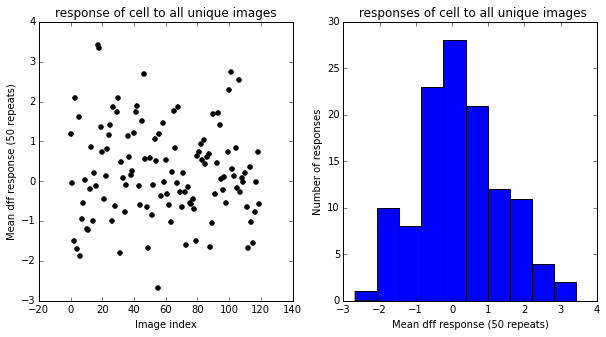

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

mean_cell = mean_over_image

######################### plot the mean response of one cell to all unique images (mean over 50 repeats of each image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,num_images-1,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('Mean dff response (50 repeats)')
axs[0].set_title('response of cell to all unique images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('Mean dff response (50 repeats)')
axs[1].set_title(' responses of cell to all unique images')
plt.tick_params(axis='y', which='both', top='off')


# Now define the sparsity of each cell's respones (lifetime sparseness) using two metrics:
Both metrics will be calculated based on the average (over 50 repeats) response to each unique image.
# 1) kurtosis of distribution of average response over 50 repeats. Higher values       indicate higher sparsity

# 2) 1- (mean response over all/mean square response over all) <-- from literature

# We'll compare these metrics on simulated and real data.


In [7]:

from scipy import stats

# define the indices 
def get_indk(data):
    return stats.kurtosis(data, axis=0, fisher=True, bias=True)

def get_indv(data):
    num_images = np.shape(data)[0]
    mean_resp_cell = np.mean(np.abs(data))
    numerator = mean_resp_cell**2
    denominator = (1/float(num_images))*np.sum(np.array(data)**2)
    sprs_indv = 1-(numerator/float(denominator))
    return sprs_indv

# test these indices on a distribution with known kurtosis (normal distribution has kurtosis of 0)
data = 15+np.random.normal(0,1,10000) #data form normal distribution

sprs_indk = get_indk(data)
sprs_indv = get_indv(data)
                 
print 'the sparsity index (k) for a normal distribution should be 0, our code gives: ' +np.str(sprs_indk)
print 'the sparsity index (v) for a normal distribution should be 0, our code gives: ' +np.str(sprs_indv)

          

the sparsity index (k) for a normal distribution should be 0, our code gives: 0.0344297433107
the sparsity index (v) for a normal distribution should be 0, our code gives: 0.00442274815402


# Now get the sparsity metric for all cells in this mouse and plot distribution

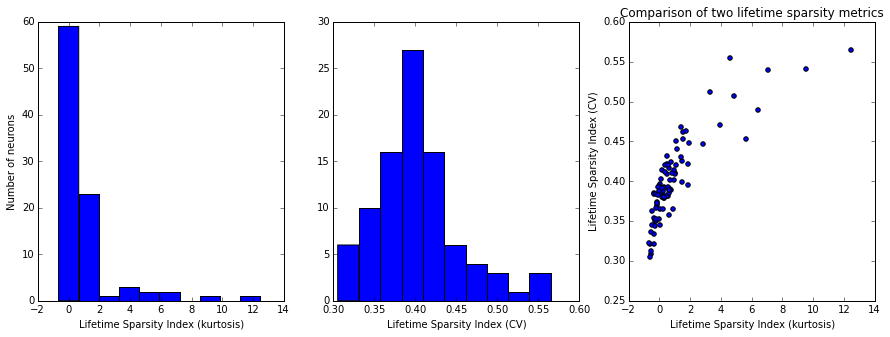

In [8]:
num_cells = np.shape(sg.response[0,0,0,:,0])[0]-1

sprs_indk = []
sprs_indv = []
for i in range(num_cells):
    mean_over_image = get_mean_over_image(sg,i)
    sprs_indk.append(get_indk(mean_over_image))
    sprs_indv.append(get_indv(mean_over_image))

# now plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()

axs[0].hist(sprs_indk)
axs[0].set_ylabel('Number of neurons')
axs[0].set_xlabel('Lifetime Sparsity Index (kurtosis)')
plt.tick_params(axis='y', which='both', top='off')

axs[1].hist(sprs_indv)
axs[1].set_xlabel('Lifetime Sparsity Index (CV)')
plt.tick_params(axis='y', which='both', top='off')


# plot the first two metrics against each other to see their correlation
axs[2].scatter(sprs_indk,sprs_indv)
axs[2].set_xlabel('Lifetime Sparsity Index (kurtosis)')
axs[2].set_ylabel('Lifetime Sparsity Index (CV)')
axs[2].set_title('Comparison of two lifetime sparsity metrics')

# Now get the population sparsity metric for all cells in this mouse.
The population sparisty metric uses the same equations (kurtosis, CV) to calculate the sparseness of responses of ALL cells to one image. This is in contrast to the 'lifetime' sparsity metric above, where the sparseness is defined over the responses of ONE cell to all images.

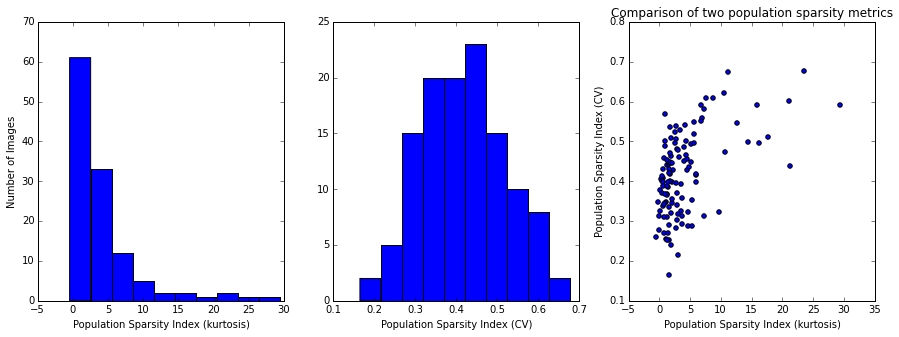

In [9]:
pop_sprs_indk = []
pop_sprs_indv = []
for i in range(num_images-1):
    mean_over_pop = get_mean_over_pop(sg,i)
    pop_sprs_indk.append(get_indk(mean_over_pop))
    pop_sprs_indv.append(get_indv(mean_over_pop))
    
# now plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()

axs[0].hist(pop_sprs_indk)
axs[0].set_ylabel('Number of Images')
axs[0].set_xlabel('Population Sparsity Index (kurtosis)')
plt.tick_params(axis='y', which='both', top='off')

axs[1].hist(pop_sprs_indv)
axs[1].set_xlabel('Population Sparsity Index (CV)')
plt.tick_params(axis='y', which='both', top='off')


# plot the first two metrics against each other to see their correlation
axs[2].scatter(pop_sprs_indk,pop_sprs_indv)
axs[2].set_xlabel('Population Sparsity Index (kurtosis)')
axs[2].set_ylabel('Population Sparsity Index (CV)')
axs[2].set_title('Comparison of two population sparsity metrics')

# Now get the mean sparsity metric averaged over each mouse, for all transgenic mice in V1, and plot distribution

In [10]:
cre_lines = ['Rbp4-Cre_KL100']
structure_ids = ['VISal', 'VISl', 'VISp', 'VISpm']

pop_sparsity_dict = {}
life_sparsity_dict = {}
for structure_id in structure_ids:
    print structure_id
    pop_sparsity_dict_cre = {}
    life_sparsity_dict_cre = {}
    for cre_line in cre_lines:
        container_list_filt = pd.DataFrame(boc.get_experiment_containers(targeted_structures=[structure_id],cre_lines=[cre_line]))

        pop_sparsity_dict_cre_container = {}
        life_sparsity_dict_cre_container = {}

        for ind in np.arange(len(container_list_filt)):
            container_id = container_list_filt['id'].values[ind]  # This goes through the different mice

            print container_id

            exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                    stimuli=[stim_info.STATIC_GRATINGS])[0]
            data_set = boc.get_ophys_experiment_data(exp['id'])
            sg = StaticGratings(data_set)
            num_cells = np.shape(sg.response[0,0,0,:,0])[0]-1

            life_sprs_indv = []
            for i in range(num_cells):
                mean_over_image = get_mean_over_image(sg,i)
                life_sprs_indv.append(get_indv(mean_over_image))
                
            pop_sprs_indv = []
            for i in range(num_images-1):
                mean_over_pop = get_mean_over_pop(sg,i)
                pop_sprs_indv.append(get_indv(mean_over_pop))
    
            pop_sparsity_dict_cre_container[container_id] = np.mean(pop_sprs_indv)
            life_sparsity_dict_cre_container[container_id] = np.mean(life_sprs_indv)
        pop_sparsity_dict_cre[cre_line] = pop_sparsity_dict_cre_container
        life_sparsity_dict_cre[cre_line] = life_sparsity_dict_cre_container
    pop_sparsity_dict[structure_id] = pop_sparsity_dict_cre
    life_sparsity_dict[structure_id] = life_sparsity_dict_cre


VISal
511510632
511499656
511510710
511510770
511510632
511499656
511510710
511510770
VISl
511510742
511510705
511511089
511510763
511510742
511510705
511511089
511510763
VISp
511510896
511510758
511510635
529770662
511510974
511510896
511510758
511510635
529770662
511510974
VISpm
511511015
511510653
511510658
511511006
511511015
511510653
511510658
511511006


In [11]:
# save the data
results_file='static_gratings_sparsity.pkl'
f=open(results_file,"wb")
cpickle.dump(life_sparsity_dict, f,protocol=cpickle.HIGHEST_PROTOCOL)
cpickle.dump(pop_sparsity_dict, f,protocol=cpickle.HIGHEST_PROTOCOL)
f.close()